# Make necessary imports 

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import pmdarima as pm
import arch
import ivolatility as ivol

#setting reindex to True to silence arch warning
from arch.__future__ import reindexing
reindexing = True

# Login to the IVolatility API

In [2]:
ivol.setLoginParams(username = 'your_IVol_username', password = 'your_IVol_password')

# Load SPX data from the IVolatility API
* We'll be importing end-of-day SPX prices from:
    * **/equities/eod/stocks-prices**
* And using 2.5 years of time-series data for our model, let's load SPX prices for the following period:
    * **Jan. 1, 2020 - Jun. 30, 2022**

In [3]:
getMarketData = ivol.setMethod('/equities/eod/stocks-prices')
marketData = getMarketData(symbol='SPX', from_='2020-01-01', to='2022-06-30')

marketData['date'] = pd.to_datetime(marketData['date'])
marketData = marketData.set_index('date')
marketData = marketData.sort_index()

#rescale close_prices by 0.1 to mitigate DataScaleWarning
scale = 0.1
close_prices = marketData['close'] * scale

___
# Auto-ARIMA model

In [4]:
model = pm.auto_arima(close_prices, start_p=1, start_q=1,
                                    test='adf',
                                    max_p=3, 
                                    max_q=3, 
                                    m=0,
                                    start_P=0, 
                                    seasonal=False,
                                    d=None, 
                                    D=1, 
                                    trace=True,
                                    error_action='ignore',  
                                    suppress_warnings=True, 
                                    stepwise=False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3893.717, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3882.334, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3875.446, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3876.975, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3879.476, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3877.919, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3877.092, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3878.569, Time=0.31 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3875.673, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3877.611, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3878.957, Time=0.26 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3880.477, Time=0.64 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3877.542, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3856.296, Time=0.37 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3880.005, Time=0.44 sec

Best mode

___
> Print Auto-ARIMA results

In [5]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  629
Model:               SARIMAX(3, 1, 1)   Log Likelihood               -1922.148
Date:                Thu, 01 Sep 2022   AIC                           3856.296
Time:                        20:24:17   BIC                           3882.952
Sample:                             0   HQIC                          3866.651
                                - 629                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1583      0.432      0.367      0.714      -0.688       1.005
ar.L1         -1.0305      0.044    -23.191      0.000      -1.118      -0.943
ar.L2         -0.0186      0.041     -0.456      0.649      -0.099       0.062
ar.L3          0.1691      0.027      6.273      0.000       0.116       0.222
ma.L1          0.9116      0.037     24.342      0.000       0.838       0.985
sigma2        26.6584      1.080     24.673      0.000      24.541      28.776
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):               232.03
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                            -0.66
Prob(H) (two-sided):                  0.87   Kurtosis:                         5.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

___
> Plot diagnostics

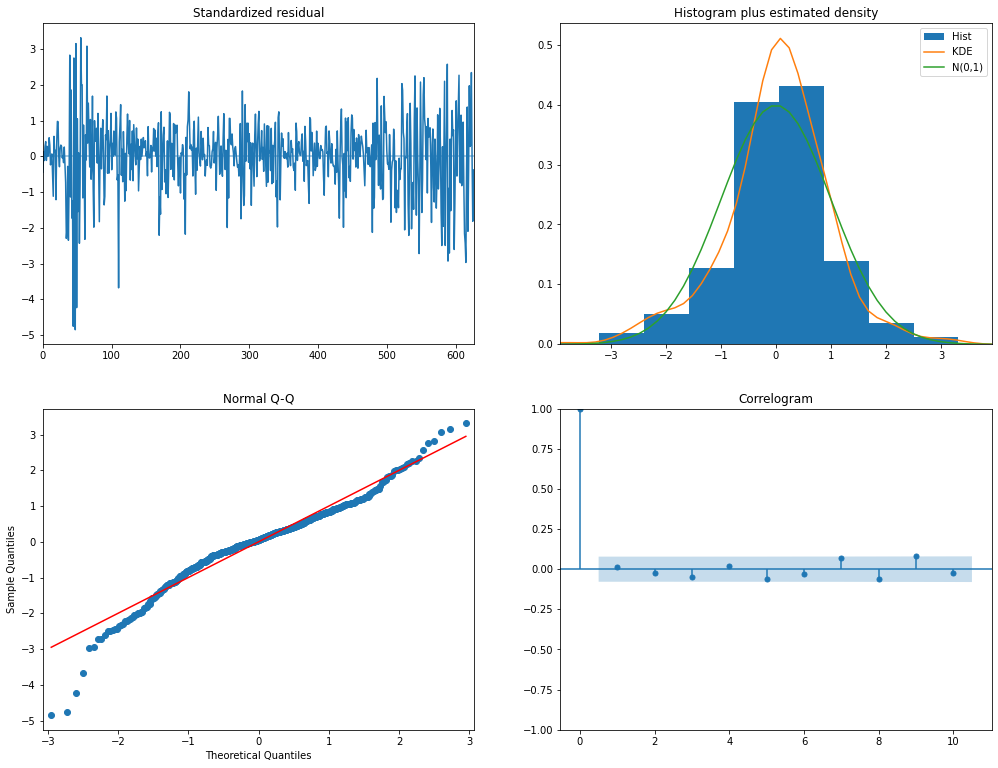

In [6]:
model.plot_diagnostics(figsize=(17,13))
plt.show()

___
> Get ARIMA residuals

In [7]:
arima_residuals = model.arima_res_.resid

___
# GARCH model
> Fit a GARCH(1,1) model on the residuals of the ARIMA model

In [8]:
garch = arch.arch_model(arima_residuals, p=1, q=1)
garch_fitted = garch.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1253711196.3840938
Iteration:      2,   Func. Count:     12,   Neg. LLF: 9575331024.388683
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1968.927329602293
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3198.9917395772336
Iteration:      5,   Func. Count:     32,   Neg. LLF: 2150.5053113365175
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1885.2766734911615
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1879.7014598709404
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1879.6636412006542
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1879.6597086512156
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1879.6596649620699
Iteration:     11,   Func. Count:     63,   Neg. LLF: 1879.659664961906
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1879.6596649620699
            Iterations: 11
            Function evaluations: 63
            Gradient evalua

___
> Print GARCH results

In [9]:
garch_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1879.66
Distribution:                  Normal   AIC:                           3767.32
Method:            Maximum Likelihood   BIC:                           3785.10
                                        No. Observations:                  629
Date:                Thu, Sep 01 2022   Df Residuals:                      628
Time:                        20:24:17   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.2741      0.152      1.805  7.104e-02 [-2.350e-02,  0.572]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          2.7777      1.231      2.256  2.409e-02 [  0.364,  5.191]
alpha[1]       0.3444  8.884e-02      3.877  1.059e-04 [  0.170,  0.519]
beta[1]        0.5772  8.760e-02      6.589  4.427e-11 [  0.406,  0.749]
========================================================================

Covariance estimator: robust
"""

___
> Plot the fitted GARCH model

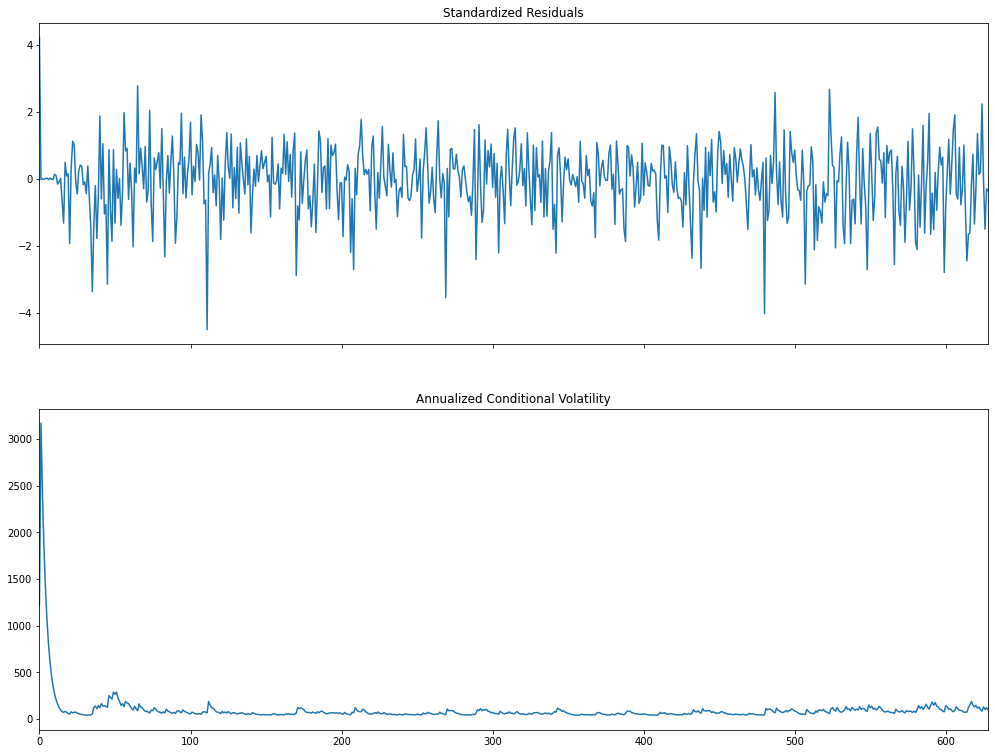

In [10]:
plt.rcParams["figure.figsize"] = (17,13)
garch_fitted.plot(annualize='D')
plt.show()

___
# Predicting the S&P 500
### We will now use the Auto-ARIMA-GARCH model from above to make a 90 day forecast

> Set the prediction period and index values for the prediction time-series

In [11]:
n_periods = 90
index_of_fc = pd.date_range(close_prices.index[-1] + datetime.timedelta(days=1), periods=n_periods)

> Use ARIMA to predict $\mu$

In [12]:
predicted_mu, confint = model.predict(n_periods=n_periods, return_conf_int=True)

> Use GARCH to predict the residual

In [13]:
garch_forecast = garch_fitted.forecast(horizon=n_periods)
predicted_et = garch_forecast.mean['h.01'].iloc[-1]
prediction = predicted_mu + predicted_et

> Rescale back

In [14]:
fitted_series = pd.Series(prediction, index=index_of_fc) / scale
lower_series = pd.Series(confint[:, 0], index=index_of_fc) / scale
upper_series = pd.Series(confint[:, 1], index=index_of_fc) / scale
close_prices = close_prices / scale

> Get the current SPX prices to compare with the model's prediction

In [15]:
marketData = getMarketData(symbol='SPX', from_='2022-07-01', to='2022-08-31')

marketData['date'] = pd.to_datetime(marketData['date'])
marketData = marketData.set_index('date')
marketData = marketData.sort_index()
actual_close_prices = marketData['close']

### Plot prediction

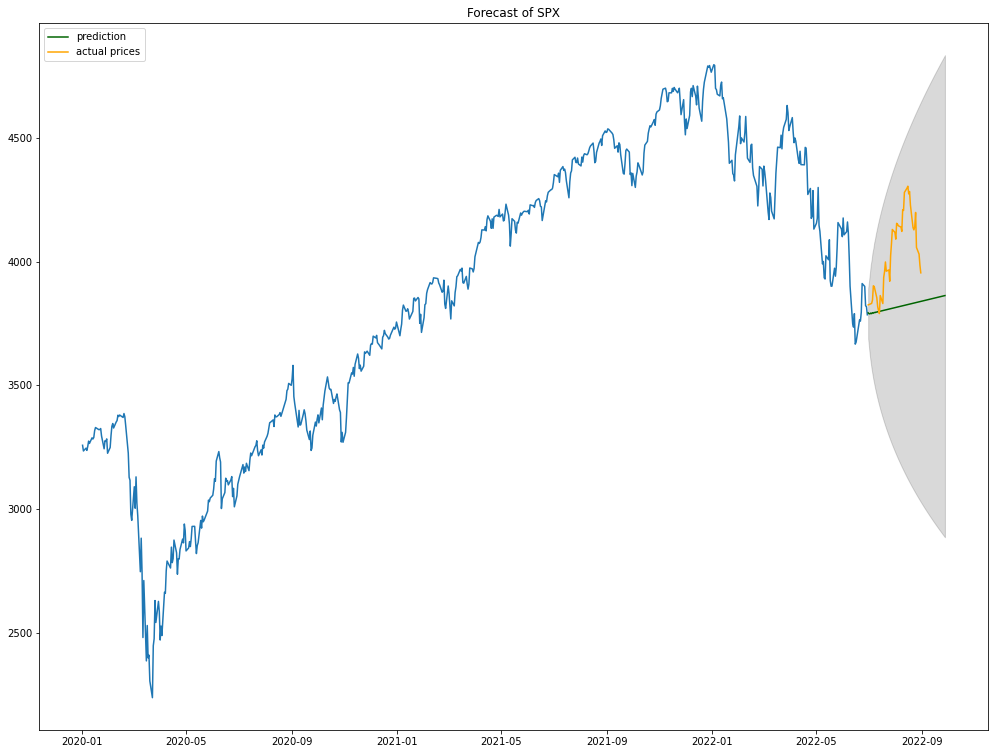

In [16]:
plt.title('Forecast of SPX')
plt.plot(close_prices)
plt.plot(fitted_series, color='darkgreen', label='prediction')
plt.plot(actual_close_prices, color='orange', label='actual prices')
plt.legend(loc="upper left")
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.rcParams["figure.figsize"] = (17,13)
plt.show()

___
## Conclusion


After a rather disappointing first half of 2022 for the S&P 500, our Auto-ARIMA-GARCH model has predicted a turnaround in the second half of the year. 

The resulting 90-day forecast, as the upward-sloping green line on the chart above shows, indicates that the S&P should resume its bull-market trend. The model also presents boundaries of the upcoming price action with the grayed-out semi-circular area. 

And, as we see with the actual performance of the S&P 500 since the beginning of July 2022, indicated by the orange curve, the US market has resumed its bull market and is staying within the bounds indicated by the model.

### IVolatility API

The IVolatility API offers a very rich abundance of financial datasets that can quickly and intuitively be loaded from the server directly into a pandas DataFrame locally. You may then use the data in a variety of avenues, such as modeling, back-testing, etc. One such way may just include making a powerful forecast of the world's most recognized and followed US market index, like the S&P 500.

Happy researching!